### Analysis and plotting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import os
import datetime as dt
import xarray as xr
from scipy import stats
import re
from scipy.signal import argrelextrema, argrelmax

# pretty print++ and pretty print
import pprintpp
pprintpp.monkeypatch()
import pprint

import warnings
warnings.filterwarnings('ignore')

# Import functions for computing summary statistics
import resampled_stats as rs

# use this function to match the date/time of observations
def nearest(items, pivot):
    # https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date
    return min(items, key=lambda x: abs(x - pivot))

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/pprintpp/__init__.py:171: UserWarning: 'pprint' has already been imported; monkeypatching won't work everywhere.
  warnings.warn("'pprint' has already been imported; monkeypatching "


Set font sizes for plots

In [2]:
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

---

# Open datasets

CUES dataset which is the merged GOES-16 brightness temperature and CUES station data:

In [3]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
cues_ds = cues_ds.to_xarray().squeeze()

GOES-16 ABI Cloud Mask product:

In [4]:
goes_cloudmask = pd.read_pickle('data/GOES-16_ABI-L2-ACMC_CUES_2017-2020.pkl')
goes_cloudmask = goes_cloudmask.to_xarray()

Round the ABI Cloud Mask timestamps to the nearest minute to match these up with the merged GOES and CUES (5-minute interval) data. Add the cloud mask to the cues_ds (**NOTE**: I have only a shorter time period covered by the cloud mask than the rest of the GOES and CUES data)

In [5]:
goes_cloudmask['datetime'] = goes_cloudmask.datetime.dt.floor('5min')
cues_ds['ABI_Cloud_Mask'] = goes_cloudmask.BCM

### Compute diff

(GOES Tb - CUES Tss) and add it to the dataset

In [6]:
# Orthorectified GOES
cues_ds['goes_cues_diff'] = cues_ds.goes_tb_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

# Not orthorecitfied, original GOES
cues_ds['goes_cues_diff_not_orthorectified'] = cues_ds.goes_tb_not_orthorectified_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

Rename the "datetime" index column to just "time".

In [7]:
cues_ds = cues_ds.rename({'datetime': 'time'})

### Filter entire dataset to only snow-on conditions, cloud-free, November through June each year

Set thresholds for where we want to ignore snow surface temperature and GOES brightness temperature measurements. It looks like I can be safe by saying "no snow" is anywhere below 5 cm of snow depth. I'll use the daily median snow depth to check this.

And of course we want no cloud-cover, so only look at where cloud_flag=0.

There are very few data points within Fall months, and we don't want to look at the summer past snowmelt. Filter to only look at November through June each year.

In [8]:
snow_depth_treshold = 5 # cm

# My original idea was to use this carefully created "cloud flag",  it seems to under-predicts true cloud cover
filter_conditions = ((cues_ds.cloud_flag == 0) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# simple Clear Sky Index > 1 means we have clouds
#filter_conditions2 = ((cues_ds.lclr_mean > cues_ds['upward looking longwave radiation; uplooking Eppley lab precision infrared long wave radiometer; (Watts/meter^2)']) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# using the sun flag doesn't make much of a difference because the Clear Sky Index LW method i'm using here is biased towards saying we have clear skies
# when cloud_flag == 0 almost always sun_flag == 1
#filter_conditions3 = (((cues_ds.cloud_flag == 0) | (cues_ds['SUN flag; uplooking Sunshine pyranometer  direct and diffuse; (bit)'] == 1)) & (cues_ds.daily_median_snow_depth >= snow_depth_treshold))

# Apply the filter, call this "cues_snow"
_cues_snow = cues_ds.where(filter_conditions)

# Finally, filter by month to only look at Dec-June for each year
cues_snow = _cues_snow.where(_cues_snow.time.dt.month.isin([1,2,3,4,5,6,11,12]), drop=True)

# Create another dataset applying the clouds filter only
cues_cloud = cues_ds.where(cues_ds.ABI_Cloud_Mask == 0)

# Create a third, combining the "snow" and "cloud" filters
cues_snow_cloud = cues_snow.where(cues_snow.ABI_Cloud_Mask == 0)

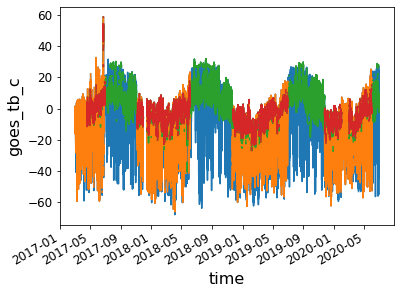

In [9]:
cues_ds.goes_tb_c.plot()
cues_snow.goes_tb_c.plot()
cues_cloud.goes_tb_c.plot()
cues_snow_cloud.goes_tb_c.plot()

Make a plot to preview some of this data showing snow melting away

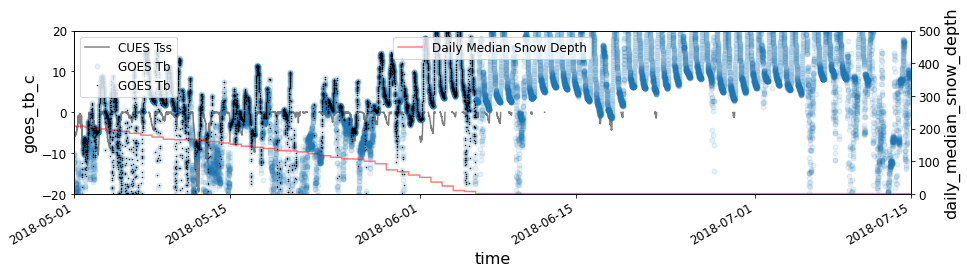

In [10]:
startdate = pd.Timestamp(2018,5,1)
enddate = pd.Timestamp(2018,7,15)

fig, ax = plt.subplots(1,1,figsize=(15,3))

cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)'].plot(linestyle='-', color='grey', ax=ax, label='CUES Tss')
cues_ds.goes_tb_c.plot(linestyle='none', marker='.', markersize=10, color='tab:blue', ax=ax, label='GOES Tb', alpha=0.1)
cues_snow.goes_tb_c.plot(linestyle='none', marker='.', markersize=1, color='k', ax=ax, label='GOES Tb')

ymax = 20
ymin = -20
ax.set_ylim([ymin,ymax])

# plot the cloud mask (this is a binary, 0 or 1), multiply by ymax on the temperature scale so that it spans the plot vertically
#ax.plot(goes_cloudmask.datetime, goes_cloudmask.BCM, color='grey', alpha=0.3, label='GOES-16 Cloud Mask', zorder=0)
#ax.plot(cues_snow.datetime, cues_ds.cloud_flag,alpha=0.3, label='CUES Cloud Flag')


ax2 = ax.twinx()
ax2.set_ylim([0,500])
cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=ax2, alpha=0.5)

ax.set_xlim([startdate,enddate])
ax.legend(loc='upper left')
ax2.legend(loc='upper center')

Make a plot showing the effect of trying to filter out cloud cover and only look at snow-on conditions:

Original, unfiltered:
{
    'intercept': -9.133482188132266,
    'max_diff': 58.89857177734375,
    'mean_diff': -5.108612667747328,
    'mean_squared_diff': 224.9377180237462,
    'median_diff': 0.7441613769531252,
    'min_diff': -65.81564453125,
    'n': 199053,
    'p_value': 0.0,
    'r_value': 0.1694393596496112,
    'range_diff': 124.71421630859375,
    'rms_diff': 14.99792379043667,
    'slope': 0.40159243598335764,
    'std_diff': 14.101056507747133,
    'std_err': 0.005235565140998692,
}
ABI Cloud Mask filter only:
{
    'intercept': 2.433015812734448,
    'max_diff': 58.89857177734375,
    'mean_diff': 4.179106658821498,
    'mean_squared_diff': 31.17169166367073,
    'median_diff': 4.128421020507813,
    'min_diff': -21.426844482421874,
    'n': 79026,
    'p_value': 0.0,
    'r_value': 0.8357263106933596,
    'range_diff': 80.32541625976562,
    'rms_diff': 5.583161439871745,
    'slope': 0.7814637183830689,
    'std_diff': 3.702264063767541,
    'std_err': 0.0018266410433

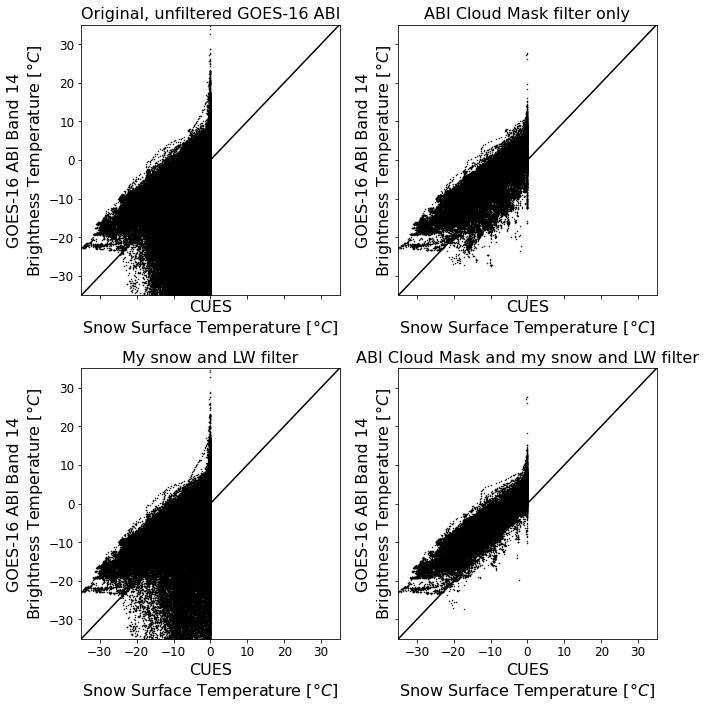

In [11]:
print("Original, unfiltered:")
x1 = cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_ds.goes_tb_c
pprint.pprint(rs.summary_stats(x1, y1))

print("ABI Cloud Mask filter only:")
x2 = cues_cloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_cloud.goes_tb_c
pprint.pprint(rs.summary_stats(x2, y2))

print("My snow and LW filter:")
x3 = cues_snow['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y3 = cues_snow.goes_tb_c
pprint.pprint(rs.summary_stats(x3, y3))

print("ABI Cloud Mask and my snow and LW filter:")
x4 = cues_snow_cloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y4 = cues_snow_cloud.goes_tb_c
pprint.pprint(rs.summary_stats(x4, y4))

### Plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,10),sharex=True,sharey=True,tight_layout=True)
[ax1, ax2, ax3, ax4] = axes.ravel()

ax1.set_title('Original, unfiltered GOES-16 ABI')
ax1.plot(x1, y1, '.k',alpha=1, markersize=1, label='unfiltered data')

ax2.set_title('ABI Cloud Mask filter only')
ax2.plot(x2, y2, '.k',alpha=1, markersize=1, label='abi cloud mask filter')

ax3.set_title('My snow and LW filter')
ax3.plot(x3, y3, '.k',alpha=1, markersize=1, label='my filter')

ax4.set_title('ABI Cloud Mask and my snow and LW filter')
ax4.plot(x4, y4, '.k',alpha=1, markersize=1, label='cloud mask and my filter')


#legend_elements= [Line2D([0], [0], marker='o', color='none', label='unfiltered data',
#                          markerfacecolor='k', markeredgecolor='none', markersize=10),
#                  Line2D([0], [0], marker='o', color='none', label='my filter',
#                          markerfacecolor='r', markeredgecolor='none', markersize=5),
#                  Line2D([0], [0], marker='o', color='none', label='abi cloud mask filtera',
#                           markerfacecolor='b', markeredgecolor='none', markersize=5),
#                  Line2D([0], [0], marker='o', color='none', label='cloud mask and my filter',
#                           markerfacecolor='c', markeredgecolor='none', markersize=5)]
#
#plt.legend(handles=legend_elements, loc='upper right')

(min_lim, max_lim) = (-35, 35)
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim((min_lim,max_lim))
    ax.set_ylim((min_lim,max_lim));
    ax.set_xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
    ax.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
    ax.plot([min_lim,max_lim],[min_lim,max_lim],'-k')

---

# Summary stats for the full time period

And a plot showing the overal change due to orthorectifying the ABI imagery. Although we see a difference here in the timeseries, any "improvement" isn't really apparent. It is much more apparent when we look at the GOES versus ASTER plots when we can actually visually see the spatial misalignment without orthorectifying the GOES imagery.

Not Orthorectified (original ABI projection):
{
    'intercept': 4.277045194734115,
    'max_diff': 59.013285038444394,
    'mean_diff': 5.664359405370893,
    'mean_squared_diff': 43.0467249413458,
    'median_diff': 5.448656415544342,
    'min_diff': -30.770639449525465,
    'n': 50243,
    'p_value': 0.0,
    'r_value': 0.8930437486934989,
    'range_diff': 89.78392448796986,
    'rms_diff': 6.561000300361661,
    'slope': 0.8527976164015051,
    'std_diff': 3.310854492141281,
    'std_err': 0.0019170238560228656,
}
Orthorectified:
{
    'intercept': 2.81593655849868,
    'max_diff': 58.89857177734375,
    'mean_diff': 4.937863674714561,
    'mean_squared_diff': 34.57934720365235,
    'median_diff': 4.475287475585937,
    'min_diff': -17.391116333007812,
    'n': 50240,
    'p_value': 0.0,
    'r_value': 0.899771161434899,
    'range_diff': 76.28968811035156,
    'rms_diff': 5.880420665535107,
    'slope': 0.774857424962884,
    'std_diff': 3.193250621793844,
    'std_err': 0.001676

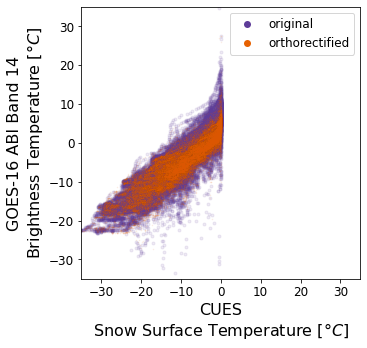

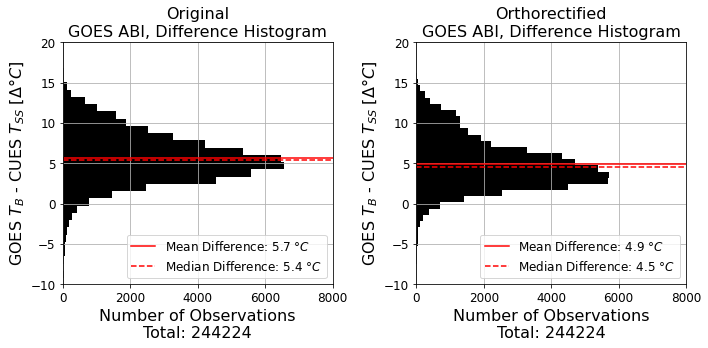

In [12]:
x1 = cues_snow_cloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y1 = cues_snow_cloud.goes_tb_not_orthorectified_c

print("Not Orthorectified (original ABI projection):")
original_summary_stats = rs.summary_stats(x1, y1)
pprint.pprint(original_summary_stats)

x2 = cues_snow_cloud['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
y2 = cues_snow_cloud.goes_tb_c

print("Orthorectified:")
ortho_summary_stats = rs.summary_stats(x2, y2)
pprint.pprint(ortho_summary_stats)


### Make 1-to-1 plot
plt.figure(figsize=(5,5))

plt.plot(x1, y1, '.', color='#5e3c99', alpha=0.1, label='original GOES')
plt.plot(x2, y2, '.', color='#e66101', alpha=0.1,markersize=1, label='orthorectified GOES')


legend_elements= [Line2D([0], [0], marker='o', color='none', label='original',
                          markerfacecolor='#5e3c99', markeredgecolor='none', markersize=7),
                  Line2D([0], [0], marker='o', color='none', label='orthorectified',
                          markerfacecolor='#e66101', markeredgecolor='none', markersize=7)]
plt.legend(handles=legend_elements, loc='upper right')

plt.xlim((-35,35))
plt.ylim((-35,35));

plt.xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
plt.ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');

### Make histograms


nbins=100
xmin=0
xmax=8000
ymin=-10
ymax=20


fig, [ax1, ax2] = plt.subplots(1,2,figsize=(10,5),tight_layout=True)

# original, not-orthorectified, difference histogram
cues_snow_cloud.goes_cues_diff_not_orthorectified.plot.hist(ax=ax1,
                      bins=nbins, 
                      orientation='horizontal',
                      color = '#000000',
                      ec='none',
                      lw=1)
#ax1.axhline(0,color='lightgrey',linestyle='-')
ax1.grid('on')
ax1.set_title('Original\nGOES ABI, Difference Histogram')
ax1.set_xlabel('Number of Observations\nTotal: {}'.format(cues_snow_cloud.goes_cues_diff_not_orthorectified.size))
ax1.set_xlim((xmin,xmax))
ax1.set_ylim(ymin,ymax);
ax1.set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
ax1.axhline(original_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(original_summary_stats['mean_diff'],1)))
ax1.axhline(original_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(original_summary_stats['median_diff'],1)))
ax1.legend(loc='lower right')

# orthorectified difference histogram

### Original Dataframe, Histogram ###
cues_snow_cloud.goes_cues_diff.plot.hist(ax=ax2,
                      bins=nbins, 
                      orientation='horizontal',
                      color = '#000000',
                      ec='none',
                      lw=1)
#ax2.axhline(0,color='lightgrey',linestyle='-')
ax2.grid('on')
ax2.set_title('Orthorectified\nGOES ABI, Difference Histogram')
ax2.set_xlabel('Number of Observations\nTotal: {}'.format(cues_snow_cloud.goes_cues_diff.size))
ax2.set_xlim((xmin,xmax))
ax2.set_ylim(ymin,ymax);
ax2.set_ylabel('GOES $T_{B}$ - CUES $T_{SS}$ [$\Delta\degree C$]')
ax2.axhline(ortho_summary_stats['mean_diff'], color='r', label='Mean Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['mean_diff'],1)))
ax2.axhline(ortho_summary_stats['median_diff'], color='r', linestyle='--', label='Median Difference: {} $\degree C$'.format(np.round(ortho_summary_stats['median_diff'],1)))
ax2.legend(loc='lower right')

---

# Boxplots and Histograms

Resample, compute summary stats

In [13]:
SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

For context, snow depth @ CUES

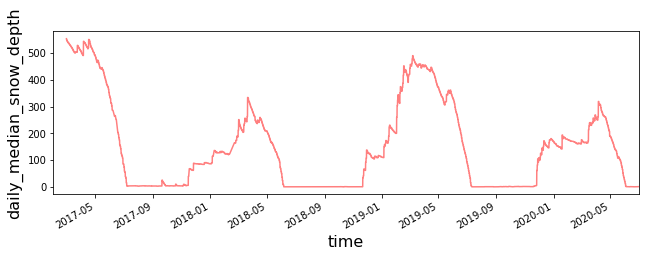

In [14]:
fig, ax = plt.subplots(figsize=(10.5,3))
cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=ax, alpha=0.5)
ax.set_xlim((pd.Timestamp('2017-02-01'),pd.Timestamp('2020-07-01')));

### 1M resample

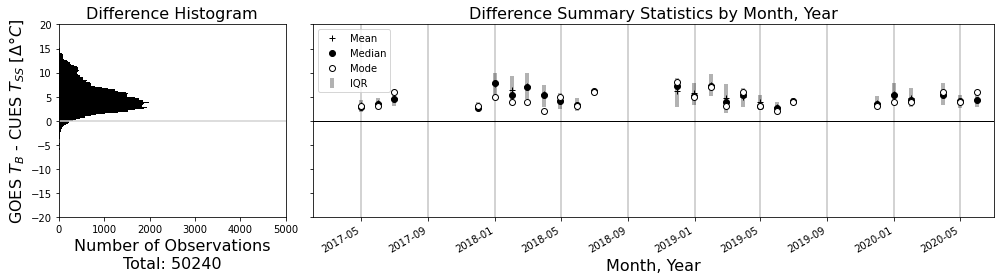

In [15]:
# Create DataArrayResample object
resampled_ds = cues_snow_cloud.goes_cues_diff.resample(time='1M')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_cloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
# Add grid
ax[1].grid(which='major', axis='x', color='lightgrey', lw=2)
ax[1].set_xlim((pd.Timestamp('2017-02-01'),pd.Timestamp('2020-07-01')));
ax[1].set_title('Difference Summary Statistics by Month, Year');
ax[1].set_xlabel('Month, Year');

## add snow depth line for context
#snowdepth_ax = ax[1].twinx()
#cues_ds.daily_median_snow_depth.plot(color='red',label='Daily Median Snow Depth', ax=snowdepth_ax, alpha=0.5)
#snowdepth_ax.set_ylabel('Snow Depth [cm]')
#snowdepth_ax.legend(loc='upper right')

### Month of Year groupby

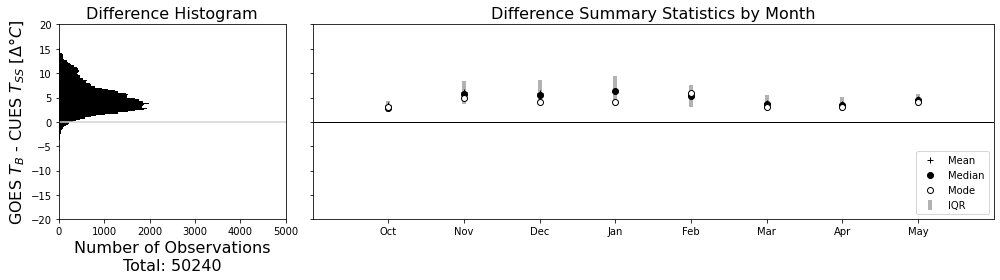

In [16]:
# Create DataArrayResample object
resampled_ds = cues_snow_cloud.goes_cues_diff.groupby('time.month')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)

def month_of_wy(month):
    ''' return month of wateryear (starting with October = 1, ending with September = 12)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if month>=10:
        return(month-9)
    else:
        return(month+3)

# calculate month of wateryear from calendar month
resampled_df['month_of_wateryear'] = [month_of_wy(month) for month in resampled_df.index]
resampled_df.set_index('month_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_cloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
 # format axis, limits and labels
ax[1].set_xlim((1,10))
ax[1].set_xticks(np.arange(2, 10, 1.0))
month_labels = [ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
ax[1].set_xticklabels(month_labels)
ax[1].set_title('Difference Summary Statistics by Month')
ax[1].set_xlabel('')
ax[1].legend(loc='lower right')

### Week of Year groupby

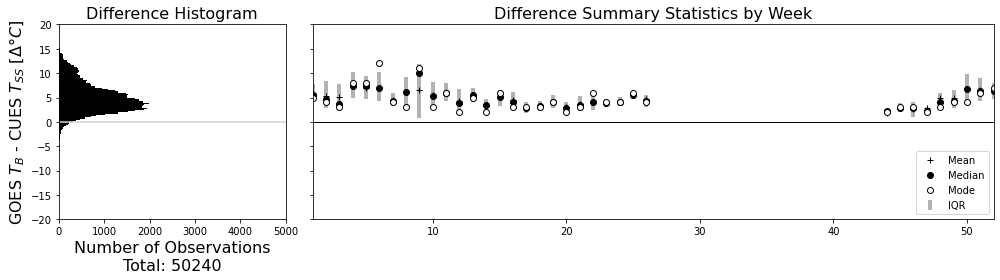

In [17]:
# Create DataArrayResample object
resampled_ds = cues_snow_cloud.goes_cues_diff.groupby('time.week')
# Run the resampled_stats function
resampled_df = rs.resampled_stats(resampled_ds, 0)


def week_of_wy(week):
    ''' return week of wateryear (starting with 1st week of October = 1, ending with last week of September = 52)
    based on: https://stackoverflow.com/questions/52105804/how-to-convert-calendar-year-to-water-year-in-pandas'''
    if week>=40:
        return(week-39)
    else:
        return(week+13)

# calculate month of wateryear from calendar month
resampled_df['week_of_wateryear'] = [week_of_wy(week) for week in resampled_df.index]
#resampled_df.set_index('week_of_wateryear', inplace=True)

# Plot the results
fig, ax = rs.resampled_plot(cues_snow_cloud.goes_cues_diff.to_dataframe(), resampled_df, ymin=-20, ymax=20, xmin=0, xmax=5000, nbins=300)
 # format axis, limits and labels
#ax[1].set_xlim((0,44))
#ax[1].set_xticks(np.arange(2, 10, 1.0))
#month_labels = [ 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun']
#ax[1].set_xticklabels(month_labels)
ax[1].set_title('Difference Summary Statistics by Week')
ax[1].set_xlabel('')
ax[1].legend(loc='lower right')

### Hour of Day, by Month groupby

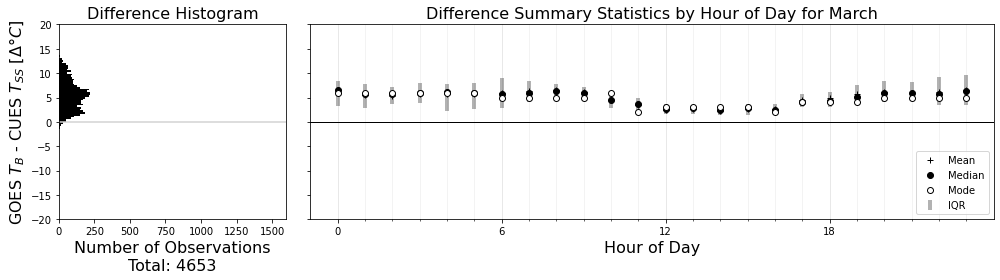

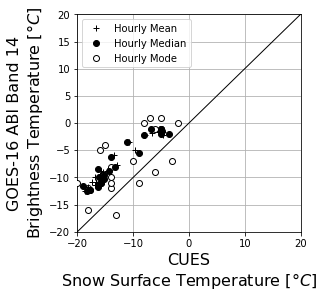

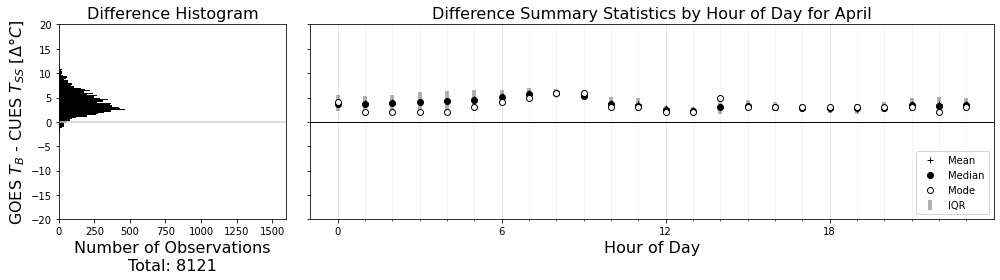

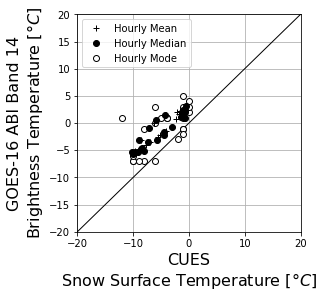

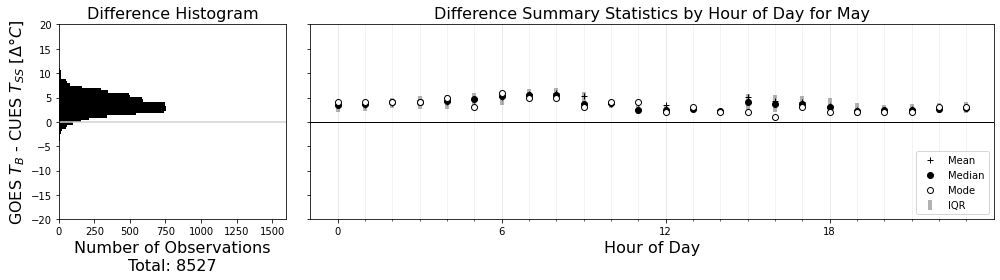

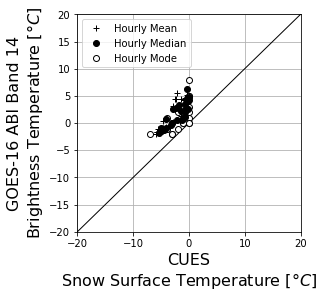

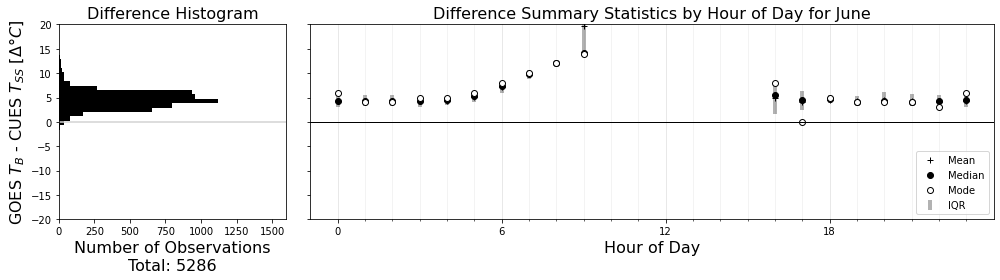

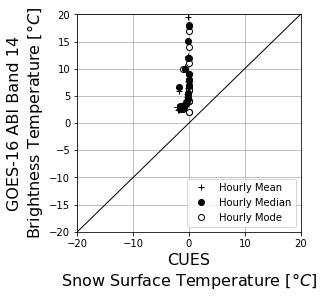

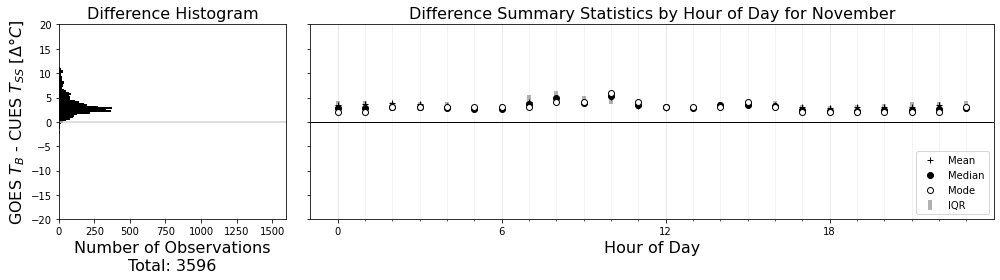

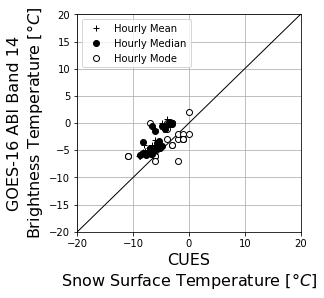

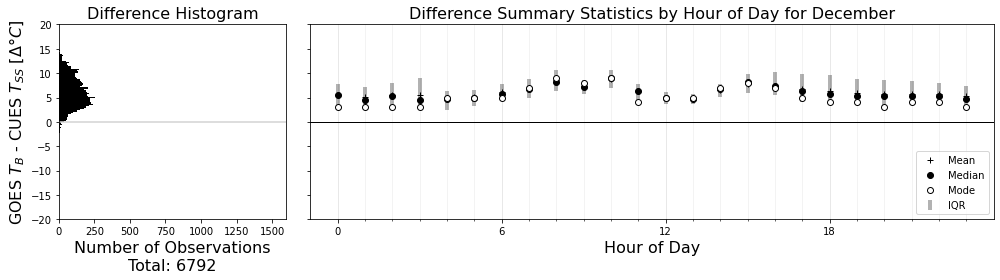

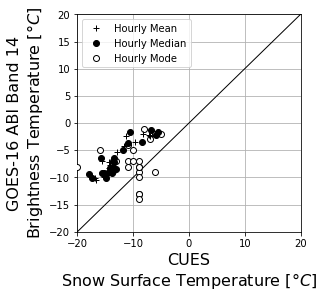

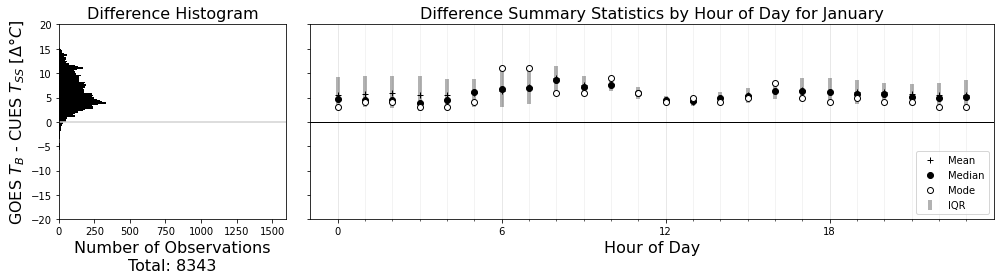

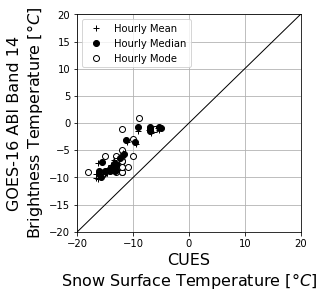

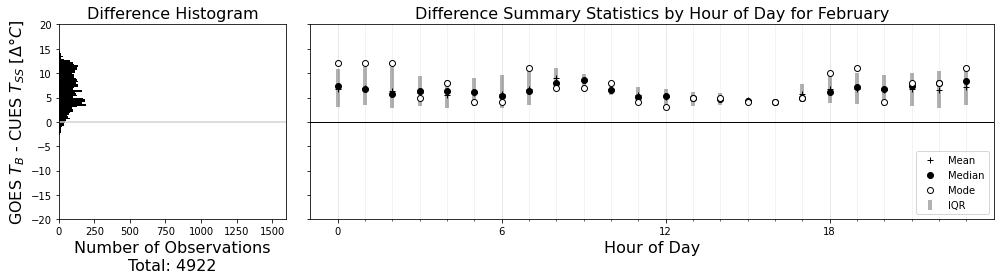

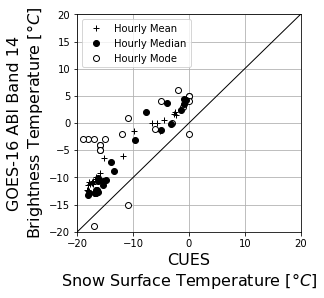

In [21]:
df = cues_snow_cloud.to_dataframe()

for month in df.index.month.unique():
    month_name = dt.date(1900, month, 1).strftime('%B')
    mask = df.index.month==month
    df_m = df.loc[mask]
    
    # Only look at aggregate months were we have more than 8000 data points (~21 days of data)
    # this gives us November - June
    if df_m.goes_cues_diff.count() >= 10:

        # Create DataArrayResample object
        resampled_ds = df_m.groupby(df_m.index.hour)
        # Run the resampled_stats function
        resampled_df = rs.resampled_stats(resampled_ds.goes_cues_diff, 0)
        
        # Plot the results
        nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
        fig, ax = rs.resampled_plot(df_m.goes_cues_diff, resampled_df, ymin=-20, ymax=20, xmin=0, xmax=1600, nbins=nbins)
        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}'.format(month_name))
        ax[1].set_xlabel('Hour of Day')
        ax[1].legend(loc='lower right')
        # Set major ticks and add grid
        ax[1].set_xticks(np.arange(0,24,6))
        ax[1].set_xticks(np.arange(0,24,1), minor = True)
        ax[1].set_xlim((-1,24))
        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);
        
        ### add another 1-to-1 plot
        resampled_x = resampled_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']
        resampled_y = resampled_ds.goes_tb_c
        fig3, ax3 = plt.subplots(figsize=(4,4))
        ax3.plot(rs.resampled_stats(resampled_x, 0)['means'], rs.resampled_stats(resampled_y, 0)['means'], linestyle='none',marker='+',color='k', zorder=98, label='Hourly Mean')
        ax3.plot(rs.resampled_stats(resampled_x, 0)['medians'], rs.resampled_stats(resampled_y, 0)['medians'], linestyle='none',marker='o',color='k', zorder=99, label='Hourly Median')
        ax3.plot(rs.resampled_stats(resampled_x, 0)['modes'], rs.resampled_stats(resampled_y, 0)['modes'], linestyle='none',marker='o',markerfacecolor='w',markeredgecolor='k', zorder=97, label='Hourly Mode')
        ax3.plot([-20,20],[-20,20],linestyle='-',color='k', lw=1)
        ax3.grid('on')
        ax3.set_xlim((-20,20))
        ax3.set_ylim((-20,20))
        ax3.set_xlabel('CUES\nSnow Surface Temperature [$\degree C$]')
        ax3.set_ylabel('GOES-16 ABI Band 14\nBrightness Temperature [$\degree C$]');
        ax3.legend()

### Hour of Day, by Season groupby

In [19]:
#for season in ['DJF', 'MAM', 'JJA']:
#    df_season = cues_snow.goes_cues_diff.where(cues_snow['datetime.season']==season).to_dataframe()
#    
#    # Only look at aggregate months were we have more than 40000 data points (~138 days of data)
#    # This avoids looking at June, July, August (therefore we only look at Dec - May)
#    if df_season.goes_cues_diff.count() >= 40000:
#
#        # Create DataArrayResample object
#        resampled_ds = df_season.goes_cues_diff.groupby(df_season.index.hour)
#        # Run the resampled_stats function
#        resampled_df = rs.resampled_stats(resampled_ds, 0)
#        
#        # Plot the results
#        #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
#        
#        # Plot the results2
#        nbins = int(np.sqrt(df_season.goes_cues_diff.count()))+1
#        fig, ax = rs.resampled_plot(df_season.goes_cues_diff, resampled_df, ymin=-20, ymax=20, xmin=0, xmax=2500, nbins=nbins)
#        ax[1].set_title('Difference Summary Statistics by Hour of Day for Months: {}'.format(season))
#        ax[1].set_xlabel('Hour of Day')
#        # Set major ticks and add grid
#        ax[1].set_xticks(np.arange(0,24,6))
#        ax[1].set_xticks(np.arange(0,24,1), minor = True)
#        ax[1].set_xlim((-1,24))
#        ax[1].grid(which='major', axis='x', color='lightgrey', lw=1, alpha=0.5);
#        ax[1].grid(which='minor', axis='x', color='lightgrey', lw=1, alpha=0.25);

### Hour of Day, by Month-Year groupby

In [20]:
#df = cues_snow.to_dataframe()
#
#for year in df.index.year.unique():
#    mask = df.index.year==year
#    df_n = df.loc[mask]
#    
#    for month in df_n.index.month.unique():
#        mask = df_n.index.month==month
#        df_m = df_n.loc[mask]
#
#        # Create DataArrayResample object
#        resampled_ds = df_m.goes_cues_diff.groupby(df_m.index.hour)
#        # Run the resampled_stats function
#        resampled_df = rs.resampled_stats(resampled_ds, 0)
#        
#        # Plot the results
#        #fig, ax = resampled_plot(resampled_df, xmin=0, xmax=20, nbins=10)
#        
#        # Plot the results2
#        nbins = int(np.sqrt(df_m.goes_cues_diff.count()))+1
#        fig, ax = resampled_plot2(df_m.goes_cues_diff, resampled_df, ymin=-10, ymax=20, xmin=0, xmax=1000, nbins=nbins)
#        ax[1].set_title('Difference Summary Statistics by Hour of Day for {}-{}'.format(month, year))
#        ax[1].set_xlabel('Hour of Day')